# 多头注意力（multihead attention）

与其只使用单独一个注意力汇聚，
我们可以用独立学习得到的$h$组不同的
*线性投影*（linear projections）来变换查询、键和值。
然后，这$h$组变换后的查询、键和值将并行地送到注意力汇聚中。
最后，将这$h$个注意力汇聚的输出拼接在一起，
并且通过另一个可以学习的线性投影进行变换，
以产生最终输出。
这种设计被称为*多头注意力*（multihead attention）
对于$h$个注意力汇聚输出，每一个注意力汇聚都被称作一个*头*（head）。
下面展示了使用全连接层来实现可学习的线性变换的多头注意力。
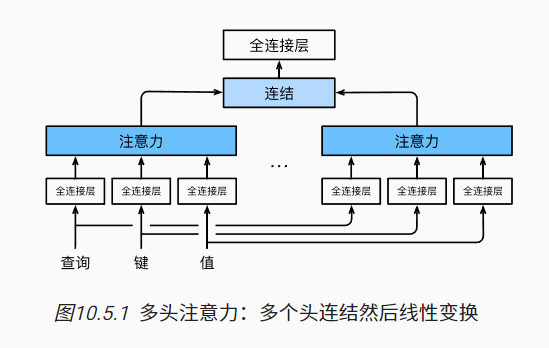

## 模型

在实现多头注意力之前，让我们用数学语言将这个模型形式化地描述出来。
给定查询$\mathbf{q} \in \mathbb{R}^{d_q}$、
键$\mathbf{k} \in \mathbb{R}^{d_k}$和
值$\mathbf{v} \in \mathbb{R}^{d_v}$，
每个注意力头$\mathbf{h}_i$（$i = 1, \ldots, h$）的计算方法为：

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

其中，可学习的参数包括
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$、
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$和
$\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$，
以及代表注意力汇聚的函数$f$。
$f$可以是加性注意力和缩放点积注意力。
多头注意力的输出需要经过另一个线性转换，
它对应着$h$个头连结后的结果，因此其可学习参数是
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$：

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

基于这种设计，每个头都可能会关注输入的不同部分，
可以表示比简单加权平均值更复杂的函数。

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 实现

在实现过程中通常[**选择缩放点积注意力作为每一个注意力头**]。
为了避免计算代价和参数代价的大幅增长，
我们设定$p_q = p_k = p_v = p_o / h$。
值得注意的是，如果将查询、键和值的线性变换的输出数量设置为
$p_q h = p_k h = p_v h = p_o$，
则可以并行计算$h$个头。
在下面的实现中，$p_o$是通过参数`num_hiddens`指定的。

In [3]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        # 创建了线性变换层（Linear Layer）来将输入的查询、键和值进行线性变换，以使它们的维度适合多头自注意力的要求
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        # 创建了另一个线性变换层，用于将多头自注意力的输出进行最终的线性变换，以匹配输出的维度
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        # 具体来说，transpose_qkv 函数的作用是将这三个张量的维度从 (batch_size, 查询/键/值的数量, num_hiddens) 转换为 (batch_size * num_heads, 查询/键/值的数量, num_hiddens / num_heads)，其中 num_heads 表示多头自注意力的头数，num_hiddens 表示每个多头的隐藏单元数。
        # 这个维度变换是为了将多头自注意力中的多个头并行处理不同部分的信息。
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够使多个头并行计算， 上面的MultiHeadAttention类将使用下面定义的两个转置函数。 具体来说，transpose_output函数反转了transpose_qkv函数的操作。

In [4]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

下面使用键和值相同的小例子来[**测试**]我们编写的`MultiHeadAttention`类。
多头注意力输出的形状是（`batch_size`，`num_queries`，`num_hiddens`）。


In [5]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [6]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

* 多头注意力融合了来自于多个注意力汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的子空间表示。
* 基于适当的张量操作，可以实现多头注意力的并行计算。

# self-attention

有了注意力机制之后，我们将词元序列输入注意力池化中， 以便同一组词元同时充当查询、键和值。</br>
具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出。 由于查询、键和值来自同一组输入，因此被称为自注意力（self-attention）

In [7]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**自注意力**]

给定一个由词元组成的输入序列$\mathbf{x}_1, \ldots, \mathbf{x}_n$，
其中任意$\mathbf{x}_i \in \mathbb{R}^d$（$1 \leq i \leq n$）。
该序列的自注意力输出为一个长度相同的序列
$\mathbf{y}_1, \ldots, \mathbf{y}_n$，其中：

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

根据定义的注意力汇聚函数$f$。
下面的代码片段是基于多头注意力对一个张量完成自注意力的计算，
张量的形状为（批量大小，时间步的数目或词元序列的长度，$d$）。
输出与输入的张量形状相同。


In [8]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [9]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

## [**位置编码**]

在处理词元序列时，循环神经网络是逐个的重复地处理词元的，
而自注意力则因为并行计算而放弃了顺序操作。
为了使用序列的顺序信息，通过在输入表示中添加
*位置编码*（positional encoding）来注入绝对的或相对的位置信息。
位置编码可以通过学习得到也可以直接固定得到。
接下来描述的是基于正弦函数和余弦函数的固定位置编码

假设输入表示$\mathbf{X} \in \mathbb{R}^{n \times d}$
包含一个序列中$n$个词元的$d$维嵌入表示。
位置编码使用相同形状的位置嵌入矩阵
$\mathbf{P} \in \mathbb{R}^{n \times d}$输出$\mathbf{X} + \mathbf{P}$，
矩阵第$i$行、第$2j$列和$2j+1$列上的元素为：

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

乍一看，这种基于三角函数的设计看起来很奇怪。
在解释这个设计之前，让我们先在下面的`PositionalEncoding`类中实现它。

In [10]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

在位置嵌入矩阵$\mathbf{P}$中，
[**行代表词元在序列中的位置，列代表位置编码的不同维度**]。
从下面的例子中可以看到位置嵌入矩阵的第$6$列和第$7$列的频率高于第$8$列和第$9$列。
第$6$列和第$7$列之间的偏移量（第$8$列和第$9$列相同）是由于正弦函数和余弦函数的交替。

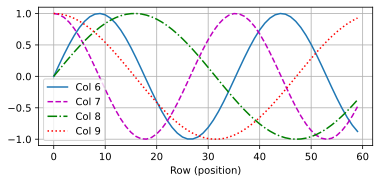

In [11]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### 绝对位置信息

为了明白沿着编码维度单调降低的频率与绝对位置信息的关系，
让我们打印出$0, 1, \ldots, 7$的[**二进制表示**]形式。
正如所看到的，每个数字、每两个数字和每四个数字上的比特值
在第一个最低位、第二个最低位和第三个最低位上分别交替。


In [12]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


在二进制表示中，较高比特位的交替频率低于较低比特位，
与下面的热图所示相似，只是位置编码通过使用三角函数[**在编码维度上降低频率**]。
由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间

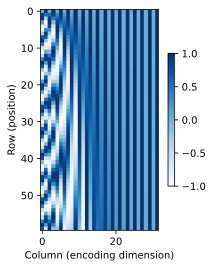

In [13]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

* 在自注意力中，查询、键和值都来自同一组输入。
* 卷积神经网络和自注意力都拥有并行计算的优势，而且自注意力的最大路径长度最短。但是因为其计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢。
* 为了使用序列的顺序信息，可以通过在输入表示中添加位置编码，来注入绝对的或相对的位置信息。